In [32]:
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")

In [33]:
data = pd.read_excel('./dataset/rt_df_thermo1.xlsx')
data.head()

,ID,formula,the thermal expansion,Normalized_Formulas
0,1,Fe3Ni,14.00,Fe0.7500Ni0.2500
1,2,Fe3Ni0.5Pt0.5,16.80,Fe0.7500Ni0.1250Pt0.1250
2,3,Fe3Pt,-30.00,Fe0.7500Pt0.2500
3,4,Fe0.75Pt0.25,-26.00,Fe0.7500Pt0.2500
4,5,Fe0.75Ni0.125Pt0.125,11.37,Fe0.7500Ni0.1250Pt0.1250


In [34]:
# 函数：解析化学成分及其比例
def parse_normalized_formulas(formula):
    """
    将Normalized_Formulas解析为化学成分及其比例。
    返回一个字典，键为化学成分，值为比例。
    """
    elements = re.findall(r'([A-Z][a-z]*)(\d*\.?\d+)', formula)
    return {element: float(ratio) for element, ratio in elements}

In [35]:
# 提取所有化学成分
all_elements = set()
for formula in data['Normalized_Formulas']:
    parsed = parse_normalized_formulas(formula)
    all_elements.update(parsed.keys())

In [36]:
all_elements

{'Al',
 'As',
 'B',
 'Ba',
 'Bi',
 'Br',
 'C',
 'Ca',
 'Cd',
 'Ce',
 'Co',
 'Cr',
 'Cs',
 'Cu',
 'Dy',
 'Er',
 'Eu',
 'F',
 'Fe',
 'Ga',
 'Gd',
 'Ge',
 'H',
 'Hf',
 'Ho',
 'I',
 'In',
 'K',
 'La',
 'Lu',
 'Mg',
 'Mn',
 'Mo',
 'N',
 'Nb',
 'Nd',
 'Ni',
 'O',
 'Os',
 'P',
 'Pb',
 'Pr',
 'Pt',
 'Rb',
 'Re',
 'Rh',
 'Ru',
 'S',
 'Sb',
 'Sc',
 'Se',
 'Si',
 'Sm',
 'Sn',
 'Sr',
 'Ta',
 'Tb',
 'Te',
 'Ti',
 'V',
 'W',
 'Y',
 'Yb',
 'Zn',
 'Zr'}

In [37]:
# 确保列顺序一致
all_elements = sorted(all_elements)

# 创建新列：每个元素作为一列，未出现的元素填充为0
for element in all_elements:
    data[element] = data['Normalized_Formulas'].apply(
        lambda x: parse_normalized_formulas(x).get(element, 0)
    )

In [38]:
data.head()

,ID,formula,the thermal expansion,Normalized_Formulas,Al,As,B,Ba,Bi,Br,...,Ta,Tb,Te,Ti,V,W,Y,Yb,Zn,Zr
0,1,Fe3Ni,14.00,Fe0.7500Ni0.2500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Fe3Ni0.5Pt0.5,16.80,Fe0.7500Ni0.1250Pt0.1250,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Fe3Pt,-30.00,Fe0.7500Pt0.2500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Fe0.75Pt0.25,-26.00,Fe0.7500Pt0.2500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Fe0.75Ni0.125Pt0.125,11.37,Fe0.7500Ni0.1250Pt0.1250,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df = data.copy()
df = df.drop('formula', axis=1)
df = df.drop('Normalized_Formulas', axis=1)
df = df.drop('ID', axis=1)
df.head()

,the thermal expansion,Al,As,B,Ba,Bi,Br,C,Ca,Cd,...,Ta,Tb,Te,Ti,V,W,Y,Yb,Zn,Zr
0,14.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-30.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-26.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 可见需要把大于3000的视为异常值

In [40]:
# 删除 'the thermal expansion' 列中大于 3000 的行
df_cleaned = df[df['the thermal expansion'] <= 3000]

In [41]:
# 删除 'the thermal expansion' 列中小于 -200 的行
df_cleaned = df_cleaned[df_cleaned['the thermal expansion'] >= -200]

# 大致符合正态分布

In [42]:
all_features = df_cleaned.drop('the thermal expansion', axis=1)
all_labels = df_cleaned['the thermal expansion']
print(f'全部的特征：{all_features.shape}')
print(f'全部的标签：{all_labels.shape}')

全部的特征：(382, 65)
全部的标签：(382,)


In [43]:
from sklearn.preprocessing import StandardScaler
import numpy as np
# 标准化特征
scaler = StandardScaler()
all_labels_scaler = scaler.fit_transform(np.array(all_labels).reshape(-1, 1))

In [44]:
from sklearn.model_selection import train_test_split
# 将总的数据集分开
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels_scaler, test_size=0.2, random_state=42)
print(f'训练集的特征：{X_train.shape}, 标签：{y_train.shape}')
print(f'测试集的特征：{X_test.shape}, 标签：{y_test.shape}')

训练集的特征：(305, 65), 标签：(305, 1)
测试集的特征：(77, 65), 标签：(77, 1)


In [45]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

第2个
第3个
第4个
第5个
第6个
第7个
第8个
第9个
第10个
第11个
第12个
第13个
第14个
第15个
第16个
第17个
第18个
第19个
第20个
第21个
第22个
第23个
第24个
第25个
第26个
第27个
第28个
第29个
第30个
第31个
第32个
第33个
第34个
第35个
第36个
第37个
第38个
第39个
第40个
第41个
第42个
第43个
第44个
第45个
第46个
第47个
第48个
第49个
第50个
第51个
第52个
第53个
第54个
第55个
第56个
第57个
第58个
第59个
第60个
第61个
第62个
第63个
第64个
第65个
第66个
第67个
第68个
第69个
第70个
第71个
第72个
第73个
第74个
第75个
第76个
第77个
第78个
第79个
第80个
第81个
第82个
第83个
第84个
第85个
第86个
第87个
第88个
第89个
第90个
第91个
第92个
第93个
第94个
第95个
第96个
第97个
第98个
第99个
第100个
第101个
第102个
第103个
第104个
第105个
第106个
第107个
第108个
第109个
第110个
第111个
第112个
第113个
第114个
第115个
第116个
第117个
第118个
第119个
第120个
第121个
第122个
第123个
第124个
第125个
第126个
第127个
第128个
第129个
第130个
第131个
第132个
第133个
第134个
第135个
第136个
第137个
第138个
第139个
第140个
第141个
第142个
第143个
第144个
第145个
第146个
第147个
第148个
第149个
第150个
第151个
第152个
第153个
第154个
第155个
第156个
第157个
第158个
第159个
第160个
第161个
第162个
第163个
第164个
第165个
第166个
第167个
第168个
第169个
第170个
第171个
第172个
第173个
第174个
第175个
第176个
第177个
第178个
第179个
第180个
第181个
第182个
第183个
第184个
第185个
第1

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

在随机森林调优 n_estimators 过程中，最好的效果：mse:0.20764, r2:0.78947, n_estimators:11


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

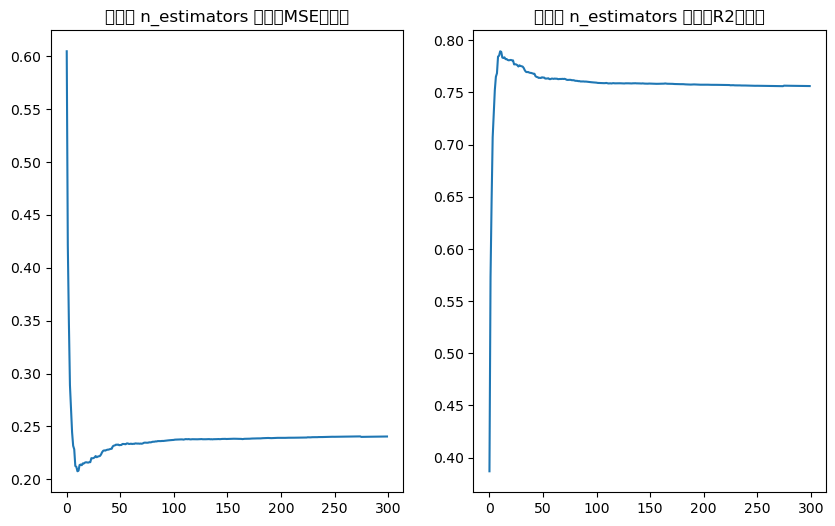

In [46]:
# 统计不同的值对随机森林的变化
cllo_mse = []
cllo_r2 = []
best_idx, best_mse, best_r2 = 0, 100, 0
# 先查找 n_estimators ，其他参数默认
for i in range(1, 301):
    print(f'第{i+1}个')
    clf = xgb.XGBRegressor(random_state=42, n_estimators=i)
    # 在训练集上拟合模型
    clf.fit(X_train,y_train)
    # 对测试集进行预测
    label_pred = clf.predict(X_test)
    # 计算MSE(平均误差)和精确度
    mse = mean_squared_error(y_test, label_pred)
    r2 = r2_score(y_test, label_pred)
    cllo_mse.append(mse)
    cllo_r2.append(r2)
    if best_mse > mse:
        best_mse = mse
        best_idx = i
        best_r2 = r2
print(f'在随机森林调优 n_estimators 过程中，最好的效果：mse:{best_mse:.5f}, r2:{best_r2:.5f}, n_estimators:{best_idx}')

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(cllo_mse)
plt.title('在调节 n_estimators 参数时MSE的变化')
plt.subplot(122)
plt.plot(cllo_r2)
plt.title('在调节 n_estimators 参数时R2的变化')
plt.show()

第2个
第3个
第4个
第5个
第6个
第7个
第8个
第9个
第10个
第11个
第12个
第13个
第14个
第15个
第16个
第17个
第18个
第19个
第20个
第21个
第22个
第23个
第24个
第25个
第26个
第27个
第28个
第29个
第30个
第31个
第32个
第33个
第34个
第35个
第36个
第37个
第38个
第39个
第40个
第41个
第42个
第43个
第44个
第45个
第46个
第47个
第48个
第49个
第50个
第51个
第52个
第53个
第54个
第55个
第56个
第57个
第58个
第59个
第60个
第61个
第62个
第63个
第64个
第65个
第66个
第67个
第68个
第69个
第70个
第71个
第72个
第73个
第74个
第75个
第76个
第77个
第78个
第79个
第80个
第81个
第82个
第83个
第84个
第85个
第86个
第87个
第88个
第89个
第90个
第91个
第92个
第93个
第94个
第95个
第96个
第97个
第98个
第99个
第100个
第101个
第102个
第103个
第104个
第105个
第106个
第107个
第108个
第109个
第110个
第111个
第112个
第113个
第114个
第115个
第116个
第117个
第118个
第119个
第120个
第121个
第122个
第123个
第124个
第125个
第126个
第127个
第128个
第129个
第130个
第131个
第132个
第133个
第134个
第135个
第136个
第137个
第138个
第139个
第140个
第141个
第142个
第143个
第144个
第145个
第146个
第147个
第148个
第149个
第150个
第151个
第152个
第153个
第154个
第155个
第156个
第157个
第158个
第159个
第160个
第161个
第162个
第163个
第164个
第165个
第166个
第167个
第168个
第169个
第170个
第171个
第172个
第173个
第174个
第175个
第176个
第177个
第178个
第179个
第180个
第181个
第182个
第183个
第184个
第185个
第1

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

第301个
在随机森林调优 leaf_size 过程中，最好的效果：mse:0.20764, r2:0.78947, leaf_size:30


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following fa

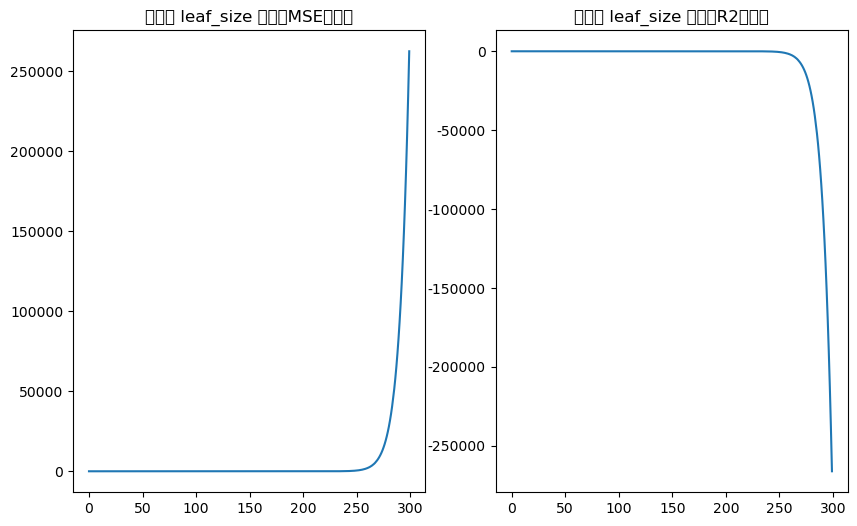

In [47]:
# 统计不同的值对随机森林的变化
cllo_mse = []
cllo_r2 = []
best_idx, best_mse, best_r2 = 0, 100, 0
# 先查找 n_estimators ，其他参数默认
for i in range(1, 301):
    print(f'第{i+1}个')
    clf = xgb.XGBRegressor(random_state=42, n_estimators=11, learning_rate=i/100)
    # 在训练集上拟合模型
    clf.fit(X_train,y_train)
    # 对测试集进行预测
    label_pred = clf.predict(X_test)
    # 计算MSE(平均误差)和精确度
    mse = mean_squared_error(y_test, label_pred)
    r2 = r2_score(y_test, label_pred)
    cllo_mse.append(mse)
    cllo_r2.append(r2)
    if best_mse > mse:
        best_mse = mse
        best_idx = i
        best_r2 = r2
print(f'在随机森林调优 leaf_size 过程中，最好的效果：mse:{best_mse:.5f}, r2:{best_r2:.5f}, leaf_size:{best_idx}')

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(cllo_mse)
plt.title('在调节 leaf_size 参数时MSE的变化')
plt.subplot(122)
plt.plot(cllo_r2)
plt.title('在调节 leaf_size 参数时R2的变化')
plt.show()

In [48]:
# 创建随机森林分类器对象
clf = xgb.XGBRegressor(random_state=42, n_estimators=11, learning_rate=0.3)
# 在训练集上拟合模型
clf.fit(X_train, y_train)
train_pred = clf.predict(X_train)
# 对测试集进行预测
label_pred = clf.predict(X_test)
# 计算MSE(平均误差)和精确度
mse = mean_squared_error(y_test, label_pred)
r2 = r2_score(y_test, label_pred)
# 输出模型评估结果和目标方程
print(f'MSE:{mse:.5f}')
print(f"R2: {r2:.5f}")

MSE:0.20764
R2: 0.78947


# 预测LiMn2O4

In [50]:
# 预测LiMn2O4
lmo_data = {
    'Normalized_Formulas': f'Li{round(1/7, 4)}Mn{round(2/7, 4)}O{round(4/7, 4)}'
}

# 根据字典初始化 DataFrame
lmo_data = pd.DataFrame(lmo_data, index=[0])

# 确保列顺序一致
all_elements = sorted(all_elements)

# 创建新列：每个元素作为一列，未出现的元素填充为0
for element in all_elements:
    lmo_data[element] = lmo_data['Normalized_Formulas'].apply(
        lambda x: parse_normalized_formulas(x).get(element, 0)
    )

print(lmo_data)

lmo_data = lmo_data.drop('Normalized_Formulas', axis=1)
print(lmo_data)

lmo_pred = clf.predict(lmo_data)

print(f'lmo_pred: {lmo_pred}')
# 将数据反归一化（归一化是 fit_transform
salered_lmo_pred = scaler.inverse_transform(lmo_pred.reshape(-1,1))
print(f'salered_lmo_pred: {salered_lmo_pred}')

       Normalized_Formulas  Al  As  B  Ba  Bi  Br  C  Ca  Cd  ...  Ta  Tb  Te  \
0  Li0.1429Mn0.2857O0.5714   0   0  0   0   0   0  0   0   0  ...   0   0   0   

   Ti  V  W  Y  Yb  Zn  Zr  
0   0  0  0  0   0   0   0  

[1 rows x 66 columns]
   Al  As  B  Ba  Bi  Br  C  Ca  Cd  Ce  ...  Ta  Tb  Te  Ti  V  W  Y  Yb  Zn  \
0   0   0  0   0   0   0  0   0   0   0  ...   0   0   0   0  0  0  0   0   0   

   Zr  
0   0  

[1 rows x 65 columns]
lmo_pred: [-0.02387825]
salered_lmo_pred: [[0.95141786]]


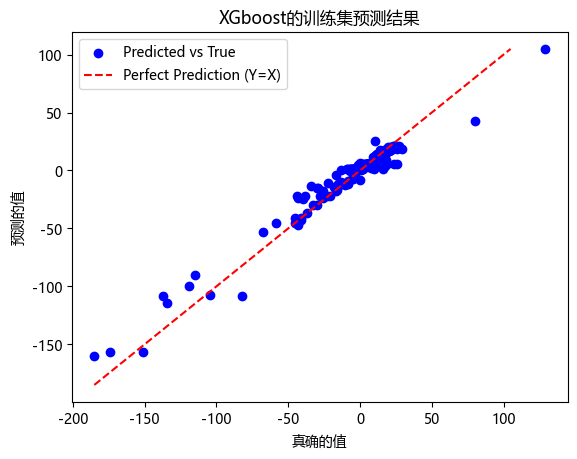

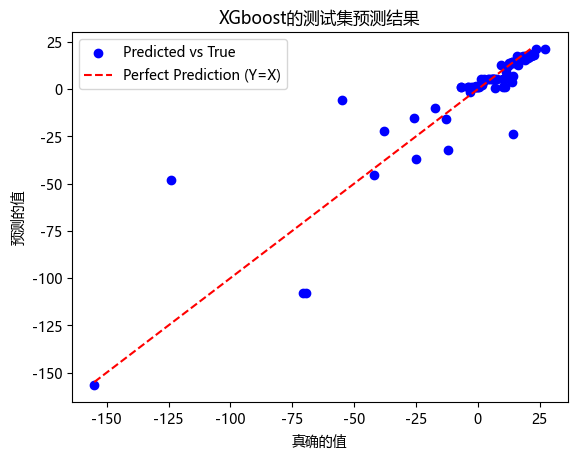

In [18]:
import matplotlib.pyplot as plt
# 先将数据反归一化
salered_train_label_pred = scaler.inverse_transform(train_pred.reshape(-1,1))
salered_train_labels = scaler.inverse_transform(y_train)
plt.scatter(salered_train_labels, salered_train_label_pred, color='blue', label='Predicted vs True')
# 绘制Y=X的直线，表示完美预测
plt.plot([min(salered_train_labels), max(salered_train_label_pred)], [min(salered_train_labels), max(salered_train_label_pred)], 'r--', label='Perfect Prediction (Y=X)')
# 添加图例
plt.legend()
# 设置坐标轴标签
plt.xlabel('真确的值')
plt.ylabel('预测的值')
# 设置标题
plt.title('XGboost的训练集预测结果')
# 显示图形
plt.show()

# 预测集
salered_test_labels = scaler.inverse_transform(y_test)
salered_label_pred = scaler.inverse_transform(label_pred.reshape(-1,1))
plt.scatter(salered_test_labels, salered_label_pred, color='blue', label='Predicted vs True')
# 绘制Y=X的直线，表示完美预测
plt.plot([min(salered_test_labels), max(salered_label_pred)], [min(salered_test_labels), max(salered_label_pred)], 'r--', label='Perfect Prediction (Y=X)')
# 添加图例
plt.legend()
# 设置坐标轴标签
plt.xlabel('真确的值')
plt.ylabel('预测的值')
# 设置标题
plt.title('XGboost的测试集预测结果')
# 显示图形
plt.show()

# 查看预测的偏差值

预测值大于原值的个数：33, 预测值小于原值的个数：44
[ 0  0  1  0  0  2 29 39  1  1  3  0  0  0]


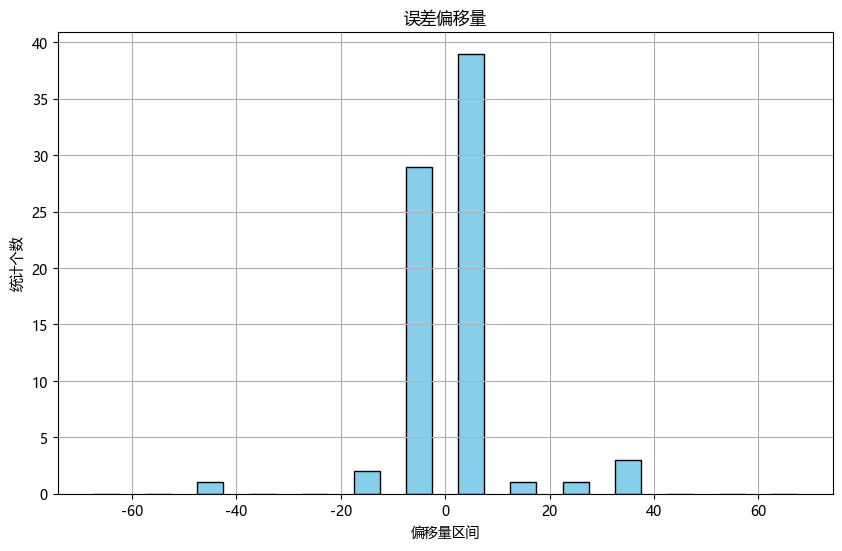

In [19]:

big_num = 0
small_num = 0
for i in range(len(label_pred)):
    if label_pred[i].mean() >= y_test[i].mean():
        big_num += 1
    else:
        small_num += 1
print(f'预测值大于原值的个数：{big_num}, 预测值小于原值的个数：{small_num}')

# 计算偏移量
value = []
for i in range(len(label_pred)):
    value.append(salered_test_labels[i] - salered_label_pred[i])

bins = np.arange(-70, 71, 10)  # 从-1到1，每隔0.1一个区间
counts, _ = np.histogram(value, bins=bins)
print(counts)
bin_centers = (bins[:-1] + bins[1:]) / 2
# 绘制柱形图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.bar(bin_centers, counts, width=5, color='skyblue', edgecolor='black')  # 宽度设置为0.1与区间宽度相匹配

# 添加标题和轴标签
plt.title('误差偏移量')
plt.xlabel('偏移量区间')
plt.ylabel('统计个数')

# 显示网格
plt.grid(True)
plt.show()